### Filtering the dataset samples before training the model

I manually listened to the dataset recordings and I observed that the noise is usually voices in the background and rustling. Thus I will need a low pass filter to cut it.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from   scipy.io import wavfile
import scipy.signal as signalpy
import wave
import sys
import math
import contextlib
import IPython
import os
import librosa
import librosa.display
import pandas as pd
import sklearn.datasets as datasets
import shutil
import scipy
from   scipy.interpolate import interp1d

### Useful functions

In [3]:
# from http://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def running_mean(x, windowSize):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

# from http://stackoverflow.com/questions/2226853/interpreting-wav-data/2227174#2227174
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels


def extract_audio(fname, tStart=None, tEnd=None):
    with contextlib.closing(wave.open(fname,'rb')) as spf:
        sampleRate = spf.getframerate()
        ampWidth = spf.getsampwidth()
        nChannels = spf.getnchannels()
        nFrames = spf.getnframes()

        startFrame, endFrame, segFrames = get_start_end_frames(nFrames, sampleRate, tStart, tEnd)

        # Extract Raw Audio from multi-channel Wav File
        spf.setpos(startFrame)
        sig = spf.readframes(segFrames)
        spf.close()

        channels = interpret_wav(sig, segFrames, nChannels, ampWidth, True)

        return (channels, nChannels, sampleRate, ampWidth, nFrames)
    
def convert_to_mono(channels, nChannels, outputType):
    if nChannels == 2:
        samples = np.mean(np.array([channels[0], channels[1]]), axis=0)  # Convert to mono
    else:
        samples = channels[0]

    return samples.astype(outputType)

def get_start_end_frames(nFrames, sampleRate, tStart=None, tEnd=None):

    if tStart and tStart*sampleRate<nFrames:
        start = tStart*sampleRate
    else:
        start = 0

    if tEnd and tEnd*sampleRate<nFrames and tEnd*sampleRate>start:
        end = tEnd*sampleRate
    else:
        end = nFrames

    return (start,end,end-start)

def plot_specgram(samples, sampleRate, tStart=None, tEnd=None):
    plt.figure(figsize=(20,10))
    plt.specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def plot_audio_samples(title, samples, sampleRate, tStart=None, tEnd=None):
    if not tStart:
        tStart = 0

    if not tEnd or tStart>tEnd:
        tEnd = len(samples)/sampleRate

    f, axarr = plt.subplots(2, sharex=True, figsize=(20,10))
    axarr[0].set_title(title)
    axarr[0].plot(np.linspace(tStart, tEnd, len(samples)), samples)
    axarr[1].specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    #get_specgram(axarr[1], samples, sampleRate, tStart, tEnd)

    axarr[0].set_ylabel('Amplitude')
    axarr[1].set_ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.show()

### Filters

In [4]:
def fir_low_pass(samples, fs, fL, N, outputType):
    # Referece: https://fiiir.com

    fL = fL / fs

    # Compute sinc filter.
    h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_high_pass(samples, fs, fH, N, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs

    # Compute sinc filter.
    h = np.sinc(2 * fH * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Create a high-pass filter from the low-pass filter through spectral inversion.
    h = -h
    h[int((N - 1) / 2)] += 1
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_band_reject(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fL.
    hlpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hlpf *= np.blackman(NL)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fH.
    hhpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hhpf *= np.blackman(NH)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NH - 1) / 2)] += 1
    # Add both filters.
    if NH >= NL:
        h = hhpf
        h[int((NH - NL) / 2) : int((NH - NL) / 2 + NL)] += hlpf
    else:
        h = hlpf
        h[int((NL - NH) / 2) : int((NL - NH) / 2 + NH)] += hhpf
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def fir_band_pass(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hlpf *= np.blackman(NH)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hhpf *= np.blackman(NL)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NL - 1) / 2)] += 1
    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def butter_low_pass(samples, fs, fL, order, outputType):
    # Normalize the cutoff frequency
    fN = fs / 2
    fL_norm = fL / fN

    # Calculate the Butterworth filter coefficients
    b, a = signalpy.butter(order, fL_norm, btype='low')

    # Apply the filter to the signal
    s = signalpy.lfilter(b, a, samples).astype(outputType)

    return s

### Creating "filtered_data" folder and filtering every file

Normally, the heart sounds frequencies are between 25Hz and 200Hz, but the murmurs can have higher frequencies (up to 500Hz). Thus, I chose to use a low pass filter, taking into consideration that there is no sound below 25Hz.

In [5]:
# Set the directory paths
input_dir   = 'phonocardiogram_dataset/training_data/training_data'
output_dir  = 'phonocardiogram_dataset/training_data/filtered_data'
folder_name = "phonocardiogram_dataset/training_data/filtered_data"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Set the filter parameters
fL = 500
order = 19
outputType = np.int16

# Iterate over all files in the input directory

for file_name in os.listdir(input_dir):
    # Check if the file is a .wav file
    if file_name.endswith('.wav'):
        # Set the input and output file paths
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name[:-4] + '_filtered.wav') # I added the _filtered suffix to the output file name
        
        # Load the audio file and apply the filter
        sample_rate, samples = wavfile.read(input_path)
        sample_low_pass = butter_low_pass(samples, sample_rate, fL, order, outputType)
        
        # Save the filtered audio to a new file
        wavfile.write(output_path, sample_rate, sample_low_pass)

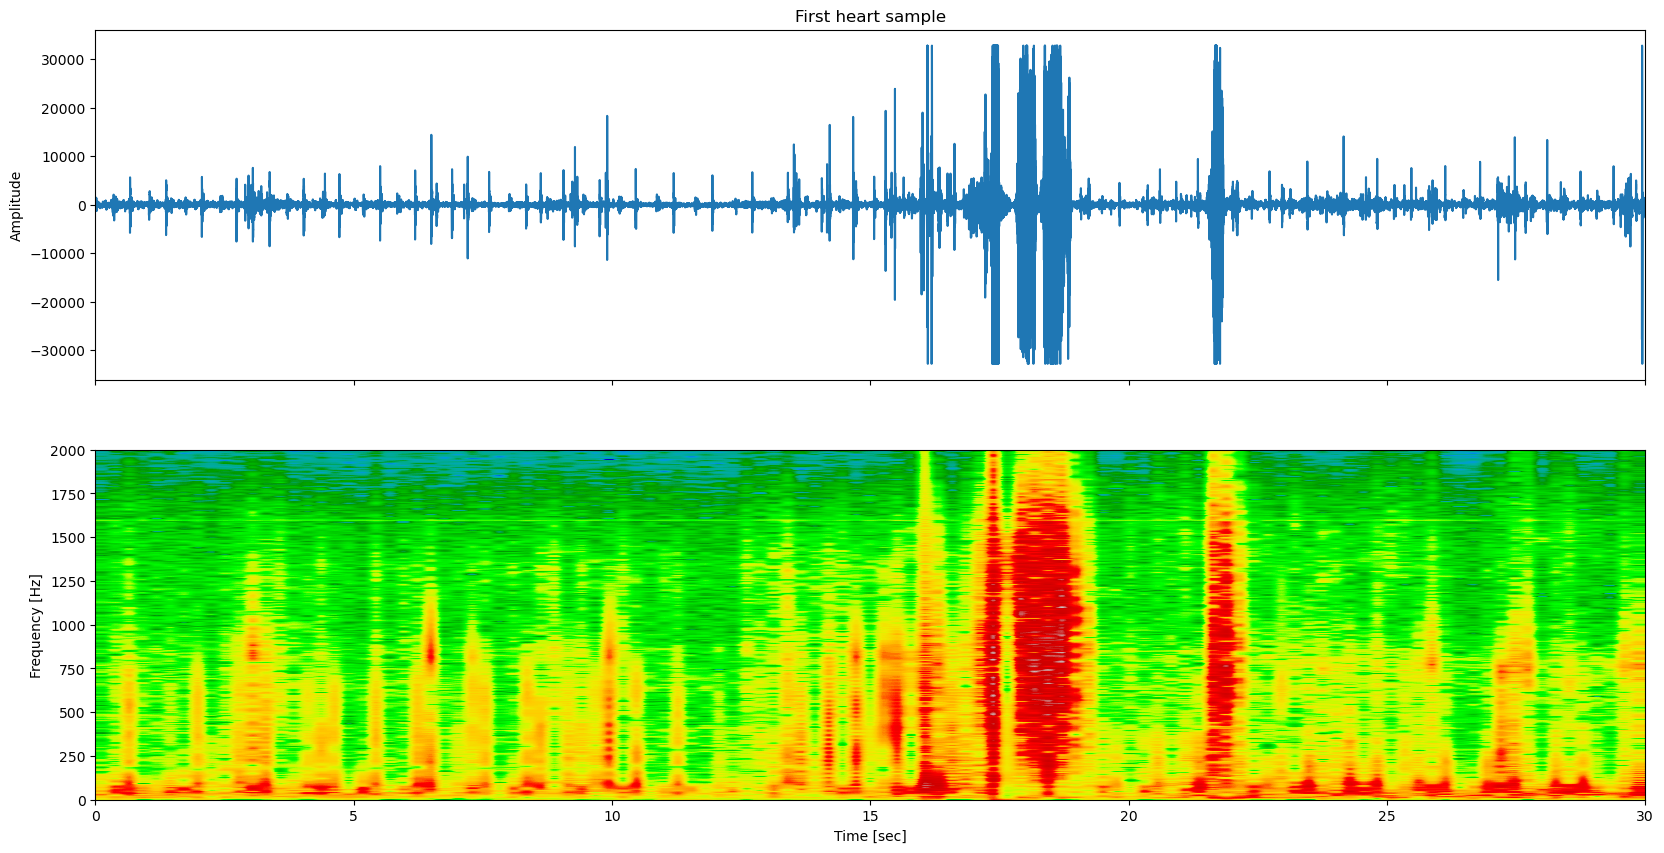

In [6]:
# 2530_AV.wav

tStart = 0
tEnd = 30

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('phonocardiogram_dataset/training_data/training_data/2530_AV.wav', tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

plot_audio_samples("First heart sample", samples, sampleRate, tStart, tEnd)

In [7]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/2530_AV.wav'

IPython.display.Audio( audio_file )

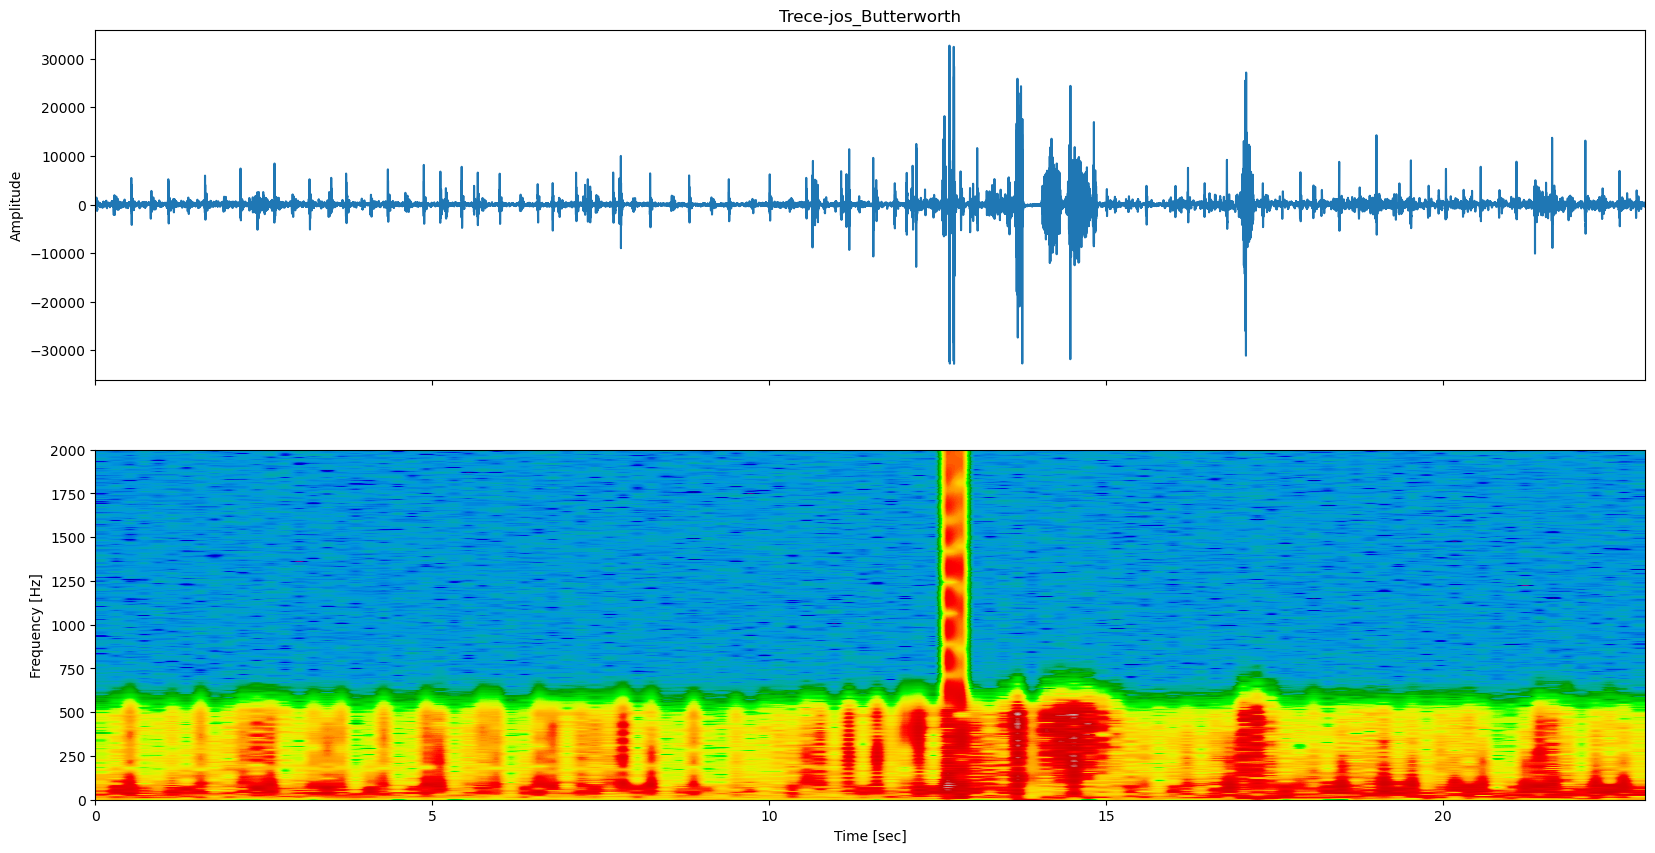

In [8]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/2530_AV.wav'

tStart=0
tEnd=23

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

#Trece jos

# sample_low_pass = fir_low_pass(samples, sampleRate , 200 , 551, np.int16)
sample_low_pass = butter_low_pass(samples, sampleRate , 500 , 19, np.int16)
plot_audio_samples("Trece-jos_Butterworth", sample_low_pass, sampleRate, tStart, tEnd)

# sample_low_pass_amplified =  np.multiply(sample_low_pass, 4)

# plot_audio_samples("Amplificat", sample_low_pass_amplified, sampleRate, tStart, tEnd)

wavfile.write('phonocardiogram_dataset/training_data/filtered_data/2530_AV_filtered.wav', sampleRate, sample_low_pass)



IPython.display.Audio( 'phonocardiogram_dataset/training_data/filtered_data/2530_AV_filtered.wav' )

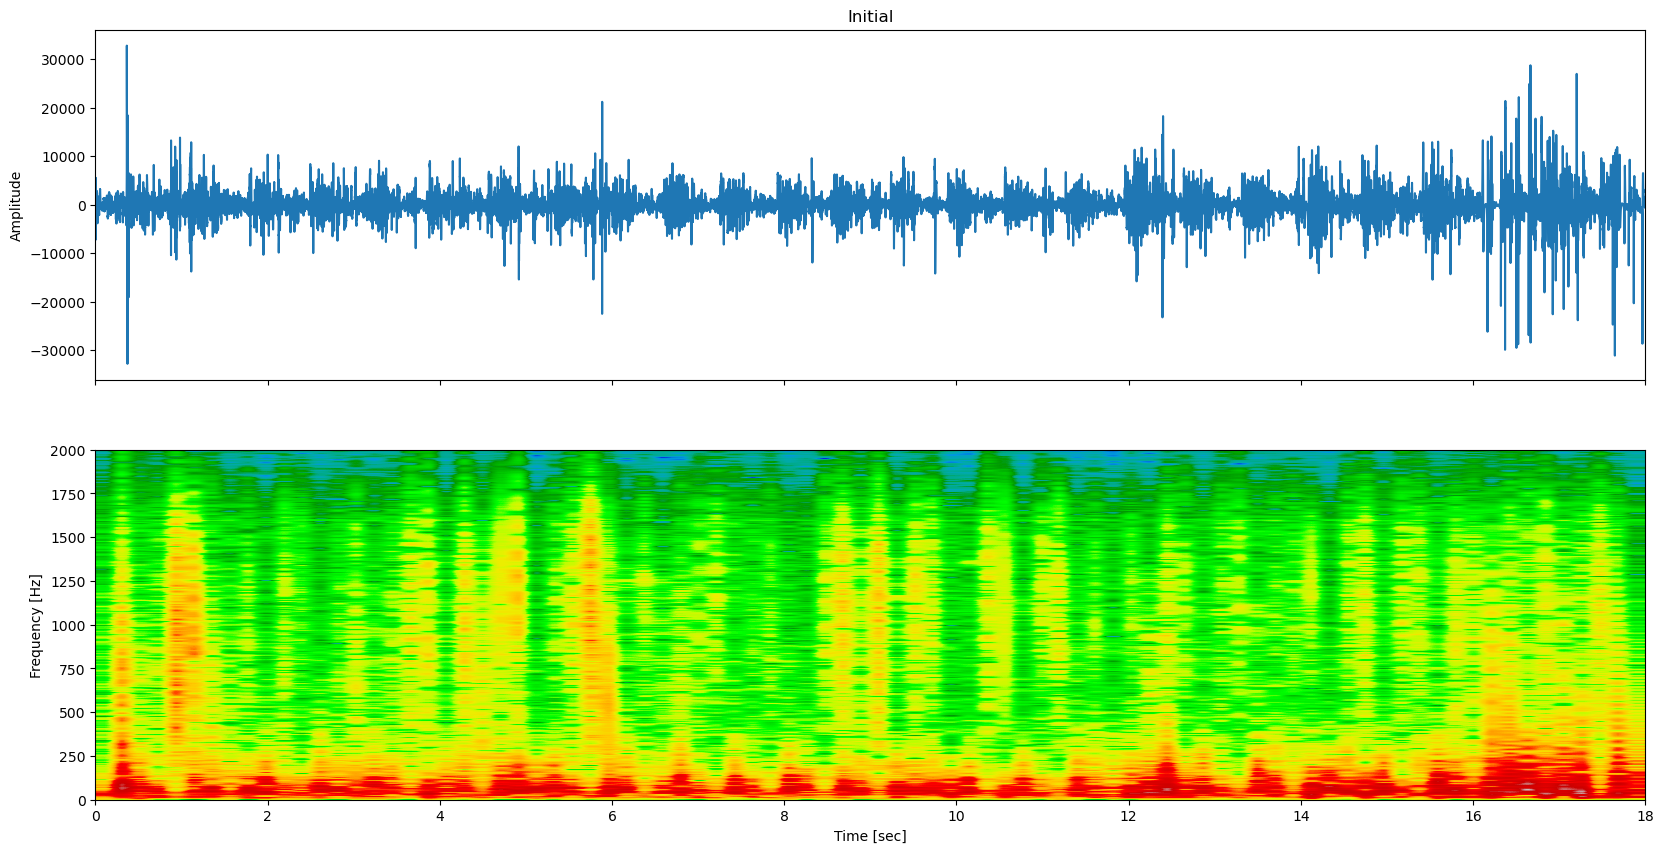

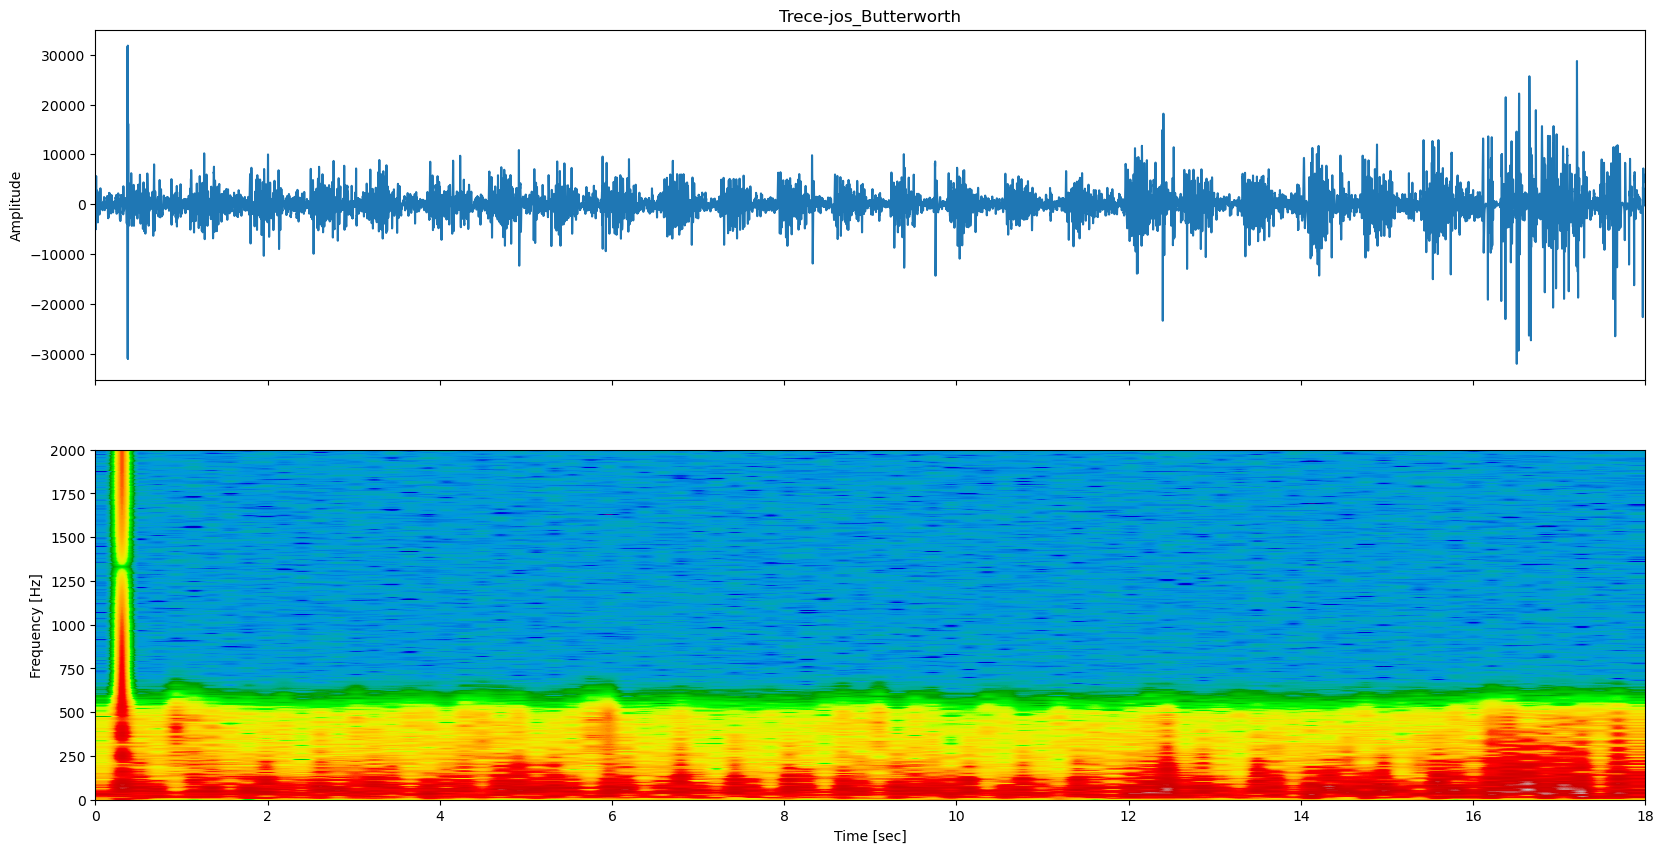

In [9]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/9979_AV.wav'

tStart=0
tEnd=18

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

plot_audio_samples("Initial", samples, sampleRate, tStart, tEnd)

#Trece jos

# sample_low_pass = fir_low_pass(samples, sampleRate , 200 , 551, np.int16)
sample_low_pass = butter_low_pass(samples, sampleRate , 500 , 19, np.int16)
plot_audio_samples("Trece-jos_Butterworth", sample_low_pass, sampleRate, tStart, tEnd)

# sample_low_pass_amplified =  np.multiply(sample_low_pass, 4)

# plot_audio_samples("Amplificat", sample_low_pass_amplified, sampleRate, tStart, tEnd)

wavfile.write('phonocardiogram_dataset/training_data/filtered_data/9979_AV_filtered.wav', sampleRate, sample_low_pass)



IPython.display.Audio( 'phonocardiogram_dataset/training_data/filtered_data/9979_AV_filtered.wav' )

### Testing the difference between filtered and non-filtered phonocardiograms

In [10]:
input_dir = 'phonocardiogram_dataset/training_data/training_data'
output_dir = 'phonocardiogram_dataset/training_data/filtered_data'
file_name = '13918_AV'

IPython.display.Audio(os.path.join(input_dir , file_name + '.wav'))

In [11]:
IPython.display.Audio(os.path.join(output_dir , file_name + '_filtered.wav'))

### Importing the dataset

In [12]:
# root_path = '/C/Users/Ema/Desktop/Phonocardiogram Analysis/'
pacient_info_initial = pd.read_csv('phonocardiogram_dataset/training_data.csv')
# Filtering pacient data. I will see if I need any of the personal information later (like sex, age, pregnancy status etc.) 
# Most probably I will drop the "Campaign" column anyway, because it is not relevant for the analysis.
# AdditionalID column is empty unless the same patient is tested multiple times in the dataset (obviously, it appears the next time with a different ID). I will keep it for now in case it is useful.
pacient_info_initial = pacient_info_initial.drop(columns=["Age", "Sex" , "Height" , "Weight", "Pregnancy status" , "Campaign"])

display(pacient_info_initial)


Patient ID    Locations   Murmur Murmur locations Most audible location  \
0          2530  AV+PV+TV+MV   Absent              NaN                   NaN   
1          9979  AV+PV+TV+MV  Present      AV+MV+PV+TV                    TV   
2          9983  AV+PV+TV+MV  Unknown              NaN                   NaN   
3         13918  AV+PV+TV+MV  Present               TV                    TV   
4         14241  AV+PV+TV+MV  Present      AV+MV+PV+TV                    PV   
..          ...          ...      ...              ...                   ...   
937       85340  AV+PV+TV+MV   Absent              NaN                   NaN   
938       85341  AV+PV+TV+MV   Absent              NaN                   NaN   
939       85343  AV+PV+TV+MV  Present            MV+TV                    TV   
940       85345        AV+PV   Absent              NaN                   NaN   
941       85349     AV+PV+TV   Absent              NaN                   NaN   

    Systolic murmur timing Systolic murmur shape Systolic murmur grading  \
0                      NaN                   NaN                     NaN   
1             Holosystolic               Diamond                  III/VI   
2                      NaN                   NaN                     NaN   
3             Holosystolic               Plateau                    I/VI   
4           Early-systolic               Plateau                   II/VI   
..                     ...                   ...                     ...   
937                    NaN                   NaN                     NaN   
938                    NaN                   NaN                     NaN   
939         Early-systolic               Plateau                    I/VI   
940                    NaN                   NaN                     NaN   
941                    NaN                   NaN                     NaN   

    Systolic murmur pitch Systolic murmur quality Diastolic murmur timing  \
0                     NaN                     NaN                     NaN   
1                    High                   Harsh                     NaN   
2                     NaN                     NaN                     NaN   
3                     Low                 Blowing                     NaN   
4                     Low                   Harsh                     NaN   
..                    ...                     ...                     ...   
937                   NaN                     NaN                     NaN   
938                   NaN                     NaN                     NaN   
939                   Low                 Blowing                     NaN   
940                   NaN                     NaN                     NaN   
941                   NaN                     NaN                     NaN   

    Diastolic murmur shape Diastolic murmur grading Diastolic murmur pitch  \
0                      NaN                      NaN                    NaN   
1                      NaN                      NaN                    NaN   
2                      NaN                      NaN                    NaN   
3                      NaN                      NaN                    NaN   
4                      NaN                      NaN                    NaN   
..                     ...                      ...                    ...   
937                    NaN                      NaN                    NaN   
938                    NaN                      NaN                    NaN   
939                    NaN                      NaN                    NaN   
940                    NaN                      NaN                    NaN   
941                    NaN                      NaN                    NaN   

    Diastolic murmur quality  Additional ID  
0                        NaN            NaN  
1                        NaN            NaN  
2                        NaN            NaN  
3                        NaN            NaN  
4                        NaN           

### Copying only the .wav files to a new folder

In [13]:
input_dir   = 'phonocardiogram_dataset/training_data/training_data/'
output_dir  = 'phonocardiogram_dataset/training_data/training_data_wavs/'




if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# iterate over all the files in the training_data folder
for file_name in os.listdir(input_dir):
    if file_name.endswith(".wav"):
        # construct the source and destination paths
        src_path = os.path.join(input_dir, file_name)
        dst_path = os.path.join(output_dir, file_name)
        # copy the file to the new folder
        shutil.copy(src_path, dst_path)

### Converting .wav files to floating point time series with librosa

In [14]:
input_dir   = 'phonocardiogram_dataset/training_data/training_data_wavs/'
signals = []
patient_IDs = []
auscultation_locations = []

for file_name in os.listdir(input_dir):
    signal, sample_rate = librosa.load(input_dir + file_name, sr=1200)
    signals.append(signal)
    patient_IDs.append(int((file_name.split('.')[0]).split('_')[0]))
    auscultation_locations.append((file_name.split('.')[0]).split('_')[1])


### Creating the pandas Dataframe with the converted signals

In [15]:
signal_dataframe = pd.DataFrame({'patient_id': patient_IDs,
                          'current_auscultation_location': auscultation_locations,
                          'signal': signals},
                         columns=['patient_id', 'current_auscultation_location' , 'signal'])

# display(signal_dataframe)

pacient_info_initial['count_auscultation_locations'] = 0


# I want to create the final dataframe concatenating the pacient_info_initial dataframe with the signal_dataframe dataframe.
# For doing that, I need to add 2 more columns:
# 1. count_auscultation_locations - the number of auscultation locations for each patient
# 2. signal - each signal for each patient
# 3. current_auscultation_location - the current auscultation location for each signal (there could be more for each patient)

for index, row in pacient_info_initial.iterrows():
    pacient_info_initial.at[index, 'count_auscultation_locations'] = len(row['Locations'].split('+'))


# IT HAS TO BE USED ONLY ONCE. OTHERWISE, IT WILL MULTIPLY THE ROWS EACH TIME IT IS RUN. - Final no. of rows = 3163
# pacient_info_initial = pacient_info_initial.loc[pacient_info_initial.index.repeat(pacient_info_initial.count_auscultation_locations)]
# pacient_info_initial.reset_index(drop=True,inplace=True)


pcg_dataframe = pd.concat([pacient_info_initial.reset_index(drop=True), signal_dataframe.sort_values(by='patient_id').reset_index(drop=True)], axis=1)

pcg_dataframe = pcg_dataframe.drop(columns=['patient_id' , 'count_auscultation_locations'])
# pcg_dataframe.columns

# For comparison - It seems correct
display(pcg_dataframe)
display(signal_dataframe.sort_values(by='patient_id').reset_index(drop=True))

if not os.path.exists('arrays/'):
    os.makedirs('arrays/')

np.save('arrays/pcg_dataframe.npy', pcg_dataframe.to_numpy())


Patient ID    Locations   Murmur Murmur locations Most audible location  \
0           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
1           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
2           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
3           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
4           9979  AV+PV+TV+MV  Present      AV+MV+PV+TV                    TV   
...          ...          ...      ...              ...                   ...   
3158       85345        AV+PV   Absent              NaN                   NaN   
3159       85345        AV+PV   Absent              NaN                   NaN   
3160       85349     AV+PV+TV   Absent              NaN                   NaN   
3161       85349     AV+PV+TV   Absent              NaN                   NaN   
3162       85349     AV+PV+TV   Absent              NaN                   NaN   

     Systolic murmur timing Systolic murmur shape Systolic murmur grading  \
0                       NaN                   NaN                     NaN   
1                       NaN                   NaN                     NaN   
2                       NaN                   NaN                     NaN   
3                       NaN                   NaN                     NaN   
4              Holosystolic               Diamond                  III/VI   
...                     ...                   ...                     ...   
3158                    NaN                   NaN                     NaN   
3159                    NaN                   NaN                     NaN   
3160                    NaN                   NaN                     NaN   
3161                    NaN                   NaN                     NaN   
3162                    NaN                   NaN                     NaN   

     Systolic murmur pitch Systolic murmur quality Diastolic murmur timing  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                     High                   Harsh                     NaN   
...                    ...                     ...                     ...   
3158                   NaN                     NaN                     NaN   
3159                   NaN                     NaN                     NaN   
3160                   NaN                     NaN                     NaN   
3161                   NaN                     NaN                     NaN   
3162                   NaN                     NaN                     NaN   

     Diastolic murmur shape Diastolic murmur grading Diastolic murmur pitch  \
0                       NaN                      NaN                    NaN   
1                       NaN                      NaN                    NaN   
2                       NaN                      NaN                    NaN   
3                       NaN                      NaN                    NaN   
4                       NaN                      NaN                    NaN   
...                     ...                      ...                    ...   
3158                    NaN                      NaN                    NaN   
3159                    NaN                      NaN                    NaN   
3160                    NaN                      NaN                    NaN   
3161                    NaN                      NaN                    NaN   
3162                    NaN                      NaN                    NaN   

     Diastolic murmur quality  Additional ID current_auscultation_location  \
0                         NaN            NaN                            TV   
1                         NaN            NaN                      

patient_id current_auscultation_location  \
0           2530                            TV   
1           2530                            PV   
2           2530                            MV   
3           2530                            AV   
4           9979                            TV   
...          ...                           ...   
3158       85345                            PV   
3159       85345                            AV   
3160       85349                            AV   
3161       85349                            PV   
3162       85349                            TV   

                                                 signal  
0     [0.044283558, 0.08357305, 0.08483126, 0.079908...  
1     [0.03783802, 0.06029642, 0.05549384, 0.0629868...  
2     [0.18855691, 0.04248511, -0.017912444, 0.01127...  
3     [0.006233137, -0.0059207836, -0.016664337, 0.0...  
4     [-0.10014393, -0.82379806, -0.6746199, -0.4551...  
...                                                 ...  
3158  [0.0065461225, 0.017596282, 0.0039989054, 0.02...  
3159  [0.030420281, 0.00832418, -0.02191807, -0.0226...  
3160  [0.002057871, -0.008989884, 0.0024980423, 0.00...  
3161  [0.07421318, 0.05925179, 0.005897636, -0.05330...  
3162  [0.08635268, 0.01259144, -0.023309037, 0.00123...  

[3163 rows x 3 columns]

#### For now, we can see that our dataset has different length signals. I will proceed to balance them so that I can feed them easily to the ML algorithms.
Moreover, at this point there are signals which are abnormal (have murmurs), normal signals (do not have murmurs), but there are also signals which are not clearly abnormal or normal. I will delete them from the dataset in order to ensure thay the predictions will be more accurate.

<Axes: >

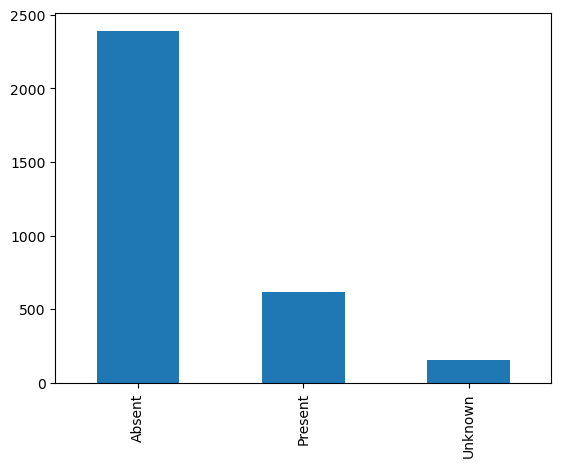

In [16]:
# We can see that there are 156 patients in the dataset where the doctor wa not sure if there was a murmur or not.
pcg_dataframe["Murmur"].value_counts()

pcg_dataframe["Murmur"].value_counts().plot(kind='bar')

In [17]:
# We will drop the rows where the doctor was not sure if there was a murmur or not

# I want to drop the rows where the doctor was not sure if there was a murmur or not. The entry for those rows is "Unknown" in the "Murmur" column.

pcg_dataframe = pcg_dataframe[pcg_dataframe.Murmur != 'Unknown']
pcg_dataframe.reset_index(inplace=True, drop=True)
display(pcg_dataframe)

Patient ID    Locations   Murmur Murmur locations Most audible location  \
0           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
1           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
2           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
3           2530  AV+PV+TV+MV   Absent              NaN                   NaN   
4           9979  AV+PV+TV+MV  Present      AV+MV+PV+TV                    TV   
...          ...          ...      ...              ...                   ...   
3002       85345        AV+PV   Absent              NaN                   NaN   
3003       85345        AV+PV   Absent              NaN                   NaN   
3004       85349     AV+PV+TV   Absent              NaN                   NaN   
3005       85349     AV+PV+TV   Absent              NaN                   NaN   
3006       85349     AV+PV+TV   Absent              NaN                   NaN   

     Systolic murmur timing Systolic murmur shape Systolic murmur grading  \
0                       NaN                   NaN                     NaN   
1                       NaN                   NaN                     NaN   
2                       NaN                   NaN                     NaN   
3                       NaN                   NaN                     NaN   
4              Holosystolic               Diamond                  III/VI   
...                     ...                   ...                     ...   
3002                    NaN                   NaN                     NaN   
3003                    NaN                   NaN                     NaN   
3004                    NaN                   NaN                     NaN   
3005                    NaN                   NaN                     NaN   
3006                    NaN                   NaN                     NaN   

     Systolic murmur pitch Systolic murmur quality Diastolic murmur timing  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                     High                   Harsh                     NaN   
...                    ...                     ...                     ...   
3002                   NaN                     NaN                     NaN   
3003                   NaN                     NaN                     NaN   
3004                   NaN                     NaN                     NaN   
3005                   NaN                     NaN                     NaN   
3006                   NaN                     NaN                     NaN   

     Diastolic murmur shape Diastolic murmur grading Diastolic murmur pitch  \
0                       NaN                      NaN                    NaN   
1                       NaN                      NaN                    NaN   
2                       NaN                      NaN                    NaN   
3                       NaN                      NaN                    NaN   
4                       NaN                      NaN                    NaN   
...                     ...                      ...                    ...   
3002                    NaN                      NaN                    NaN   
3003                    NaN                      NaN                    NaN   
3004                    NaN                      NaN                    NaN   
3005                    NaN                      NaN                    NaN   
3006                    NaN                      NaN                    NaN   

     Diastolic murmur quality  Additional ID current_auscultation_location  \
0                         NaN            NaN                            TV   
1                         NaN            NaN                      

### Binarizing data based on presence/absence of the murmur

In [18]:
# I want to binarize the "Murmur" column. The values will be 0 for "Absent" and 1 for "Present"

# IT HAS TO BE USED ONLY ONCE. OTHERWISE, IT WILL REPLACE MURMUR COLUMN VALUES WITH NaN, BECAUSE IT CANNOT MAP PROPERLY.
# pcg_dataframe["Murmur"] = pcg_dataframe["Murmur"].map({'Absent': 0, 'Present': 1})
display(pcg_dataframe)
pcg_dataframe["Murmur"].value_counts()

Patient ID    Locations  Murmur Murmur locations Most audible location  \
0           2530  AV+PV+TV+MV       0              NaN                   NaN   
1           2530  AV+PV+TV+MV       0              NaN                   NaN   
2           2530  AV+PV+TV+MV       0              NaN                   NaN   
3           2530  AV+PV+TV+MV       0              NaN                   NaN   
4           9979  AV+PV+TV+MV       1      AV+MV+PV+TV                    TV   
...          ...          ...     ...              ...                   ...   
3002       85345        AV+PV       0              NaN                   NaN   
3003       85345        AV+PV       0              NaN                   NaN   
3004       85349     AV+PV+TV       0              NaN                   NaN   
3005       85349     AV+PV+TV       0              NaN                   NaN   
3006       85349     AV+PV+TV       0              NaN                   NaN   

     Systolic murmur timing Systolic murmur shape Systolic murmur grading  \
0                       NaN                   NaN                     NaN   
1                       NaN                   NaN                     NaN   
2                       NaN                   NaN                     NaN   
3                       NaN                   NaN                     NaN   
4              Holosystolic               Diamond                  III/VI   
...                     ...                   ...                     ...   
3002                    NaN                   NaN                     NaN   
3003                    NaN                   NaN                     NaN   
3004                    NaN                   NaN                     NaN   
3005                    NaN                   NaN                     NaN   
3006                    NaN                   NaN                     NaN   

     Systolic murmur pitch Systolic murmur quality Diastolic murmur timing  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                     High                   Harsh                     NaN   
...                    ...                     ...                     ...   
3002                   NaN                     NaN                     NaN   
3003                   NaN                     NaN                     NaN   
3004                   NaN                     NaN                     NaN   
3005                   NaN                     NaN                     NaN   
3006                   NaN                     NaN                     NaN   

     Diastolic murmur shape Diastolic murmur grading Diastolic murmur pitch  \
0                       NaN                      NaN                    NaN   
1                       NaN                      NaN                    NaN   
2                       NaN                      NaN                    NaN   
3                       NaN                      NaN                    NaN   
4                       NaN                      NaN                    NaN   
...                     ...                      ...                    ...   
3002                    NaN                      NaN                    NaN   
3003                    NaN                      NaN                    NaN   
3004                    NaN                      NaN                    NaN   
3005                    NaN                      NaN                    NaN   
3006                    NaN                      NaN                    NaN   

     Diastolic murmur quality  Additional ID current_auscultation_location  \
0                         NaN            NaN                            TV   
1                         NaN            NaN                            PV   


0    2391
1     616
Name: Murmur, dtype: int64

### Balancing the length of the signals.
 1. Signals longer than the average => cut them.
 2. Signals shorter than the average => liniar interpolation

In [33]:
# display(signal_dataframe)
# Will reuse the signal_dataframe dataframe from above

signal_dataframe = pcg_dataframe["signal"]
# display(signal_dataframe)
lengths = []

for signal in signal_dataframe:
    lengths.append(len(signal))

average_length = np.mean(lengths)
# sample rate = 1200
average_length_seconds = round(average_length/1200)

print("The average length of the signals is: " , average_length_seconds , 'seconds')

balanced_signals = []

for signal in signal_dataframe :
    if len(signal) == average_length :
        balanced_signals.append(signal)
    if len(signal) > average_length :
        balanced_signals.append(signal[0:int(average_length)])
    if len(signal) < average_length : 
        # Linear Interpolation
        # new_values = np.linspace(0, len(signal)-1, num=int(average_length)-len(signal))
        # interpolated_values = np.interp(new_values, np.arange(len(signal)), signal)
        # padded_signal = np.concatenate([signal, interpolated_values])
        # balanced_signals.append(padded_signal)

        # Cubic Interpolation
        x_old = np.arange(len(signal))
        y_old = signal
        f = interp1d(x_old, y_old, kind='cubic')
        x_new = np.linspace(0, len(signal)-1, num=int(average_length)-len(signal))
        padded_signal = np.concatenate([signal, f(x_new)])
        balanced_signals.append(padded_signal)
       


# display(balanced_signals)

The average length of the signals is:  23 seconds


### Now I have to merge the pcg_dataframe signals with the padded signals

In [45]:
# balanced_signals_dataframe = pd.DataFrame(balanced_signals)
display(signal_dataframe)
display(balanced_signals)

0       [0.044283558, 0.08357305, 0.08483126, 0.079908...
1       [0.03783802, 0.06029642, 0.05549384, 0.0629868...
2       [0.18855691, 0.04248511, -0.017912444, 0.01127...
3       [0.006233137, -0.0059207836, -0.016664337, 0.0...
4       [-0.10014393, -0.82379806, -0.6746199, -0.4551...
                              ...                        
3002    [0.0065461225, 0.017596282, 0.0039989054, 0.02...
3003    [0.030420281, 0.00832418, -0.02191807, -0.0226...
3004    [0.002057871, -0.008989884, 0.0024980423, 0.00...
3005    [0.07421318, 0.05925179, 0.005897636, -0.05330...
3006    [0.08635268, 0.01259144, -0.023309037, 0.00123...
Name: signal, Length: 3007, dtype: object

array([[ 0.04428356,  0.08357305,  0.08483126, ..., -0.02213163,
         0.0360193 ,  0.        ],
       [ 0.03783802,  0.06029642,  0.05549384, ..., -0.06139453,
        -0.03247141,  0.        ],
       [ 0.18855691,  0.04248511, -0.01791244, ...,  0.28258502,
         0.23062131,  0.14469288],
       ...,
       [ 0.00205787, -0.00898988,  0.00249804, ...,  0.00588843,
         0.19711504, -0.05632662],
       [ 0.07421318,  0.05925179,  0.00589764, ..., -0.02336963,
         0.00817627,  0.        ],
       [ 0.08635268,  0.01259144, -0.02330904, ...,  0.01838567,
        -0.01804134,  0.03651306]])

In [55]:
balanced_signals_dataframe = pd.DataFrame([{'signal': lst} for lst in balanced_signals], index=signal_dataframe.index, columns = ['signal'])
display(balanced_signals_dataframe)
# only updating the "signal" column
pcg_dataframe.update(balanced_signals_dataframe)

# make sure to fill in any missing values with NaNs, even though there should be none
pcg_dataframe.fillna(value=np.nan, inplace=True)
display(pcg_dataframe)

np.save('arrays/pcg_dataframe_binarized_padded.npy', pcg_dataframe.to_numpy())

signal
0     [0.044283557683229446, 0.08357305079698563, 0....
1     [0.03783801943063736, 0.06029642000794411, 0.0...
2     [0.18855690956115723, 0.042485110461711884, -0...
3     [0.006233137100934982, -0.005920783616602421, ...
4     [-0.1001439318060875, -0.8237980604171753, -0....
...                                                 ...
3002  [0.00654612248763442, 0.017596282064914703, 0....
3003  [0.03042028099298477, 0.00832417979836464, -0....
3004  [0.0020578710827976465, -0.008989883586764336,...
3005  [0.0742131769657135, 0.05925178900361061, 0.00...
3006  [0.08635268360376358, 0.012591440230607986, -0...

[3007 rows x 1 columns]

Patient ID    Locations  Murmur Murmur locations Most audible location  \
0           2530  AV+PV+TV+MV       0              NaN                   NaN   
1           2530  AV+PV+TV+MV       0              NaN                   NaN   
2           2530  AV+PV+TV+MV       0              NaN                   NaN   
3           2530  AV+PV+TV+MV       0              NaN                   NaN   
4           9979  AV+PV+TV+MV       1      AV+MV+PV+TV                    TV   
...          ...          ...     ...              ...                   ...   
3002       85345        AV+PV       0              NaN                   NaN   
3003       85345        AV+PV       0              NaN                   NaN   
3004       85349     AV+PV+TV       0              NaN                   NaN   
3005       85349     AV+PV+TV       0              NaN                   NaN   
3006       85349     AV+PV+TV       0              NaN                   NaN   

     Systolic murmur timing Systolic murmur shape Systolic murmur grading  \
0                       NaN                   NaN                     NaN   
1                       NaN                   NaN                     NaN   
2                       NaN                   NaN                     NaN   
3                       NaN                   NaN                     NaN   
4              Holosystolic               Diamond                  III/VI   
...                     ...                   ...                     ...   
3002                    NaN                   NaN                     NaN   
3003                    NaN                   NaN                     NaN   
3004                    NaN                   NaN                     NaN   
3005                    NaN                   NaN                     NaN   
3006                    NaN                   NaN                     NaN   

     Systolic murmur pitch Systolic murmur quality Diastolic murmur timing  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                     High                   Harsh                     NaN   
...                    ...                     ...                     ...   
3002                   NaN                     NaN                     NaN   
3003                   NaN                     NaN                     NaN   
3004                   NaN                     NaN                     NaN   
3005                   NaN                     NaN                     NaN   
3006                   NaN                     NaN                     NaN   

     Diastolic murmur shape Diastolic murmur grading Diastolic murmur pitch  \
0                       NaN                      NaN                    NaN   
1                       NaN                      NaN                    NaN   
2                       NaN                      NaN                    NaN   
3                       NaN                      NaN                    NaN   
4                       NaN                      NaN                    NaN   
...                     ...                      ...                    ...   
3002                    NaN                      NaN                    NaN   
3003                    NaN                      NaN                    NaN   
3004                    NaN                      NaN                    NaN   
3005                    NaN                      NaN                    NaN   
3006                    NaN                      NaN                    NaN   

     Diastolic murmur quality  Additional ID current_auscultation_location  \
0                         NaN            NaN                            TV   
1                         NaN            NaN                            PV   


In [56]:
pcg_dataframe.shape

(3007, 18)